# ODE example of 2 linear coupled oscillators (2nd order → 1st order)

## 2nd order model

Consider two masses on a line $m_1, m_2$, each tied to walls with springs $k$ and dampers $c$:

$$
\begin{aligned}
m_1 \ddot x_1 + c_1 \dot x_1 + k_1 x_1 + c_{12}(\dot x_1 - \dot x_2) + k_{12}(x_1 - x_2) &= 0, \\
m_2 \ddot x_2 + c_2 \dot x_2 + k_2 x_2 + c_{12}(\dot x_2 - \dot x_1) + k_{12}(x_2 - x_1) &= 0.
\end{aligned}
$$

## 1st order model

In order to convert this to a first order ODE, we define the state vector:
$$
\mathbf{y} = \begin{bmatrix} x_1 \\ v_1 \\ x_2 \\ v_2 \end{bmatrix}
\quad\text{with}\quad v_i=\dot x_i.
$$

Then $\dot x_1 = v_1$, $\dot x_2 = v_2$. Next, we rewrite $\dot(v_1)$ and $\dot(v_2)$ by isolating them from the original second-order equations:

$$
\begin{aligned}
\dot v_1 &= \frac{ - (c_1+c_{12}) v_1 + c_{12} v_2 - (k_1+k_{12}) x_1 + k_{12} x_2 }{m_1}, \\[4pt]
\dot v_2 &= \frac{ \phantom{-}c_{12} v_1 - (c_2+c_{12}) v_2 + k_{12} x_1 - (k_2+k_{12}) x_2 }{m_2}.
\end{aligned}
$$

Therefore, the system can be written in compact form as, $\dot{\mathbf{y}} = A \mathbf{y}$ where

$$
A = \begin{bmatrix}
0 & 1 & 0 & 0 \\
-\frac{k_1+k_{12}}{m_1} & -\frac{c_1+c_{12}}{m_1} & \frac{k_{12}}{m_1} & \frac{c_{12}}{m_1} \\
0 & 0 & 0 & 1 \\
\frac{k_{12}}{m_2} & \frac{c_{12}}{m_2} & -\frac{k_2+k_{12}}{m_2} & -\frac{c_2+c_{12}}{m_2}
\end{bmatrix}.
$$


In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from scipy.linalg import expm
from numpy.linalg import solve


In [2]:
# Parameters of the system
m1, m2 = 1.0, 1.2          # masses
c1, c2 = 0.4, 0.3          # damping to ground
k1, k2 = 4.0, 2.5          # stiffness to ground
c12, k12 = 0.1, 1.0        # coupling (damping and stiffness)

A = np.array([
    [0.0,                 1.0,                 0.0,                 0.0],
    [-(k1+k12)/m1,  -(c1+c12)/m1,        k12/m1,           c12/m1],
    [0.0,                 0.0,                 0.0,                 1.0],
    [ k12/m2,           c12/m2,       -(k2+k12)/m2,    -(c2+c12)/m2]
], dtype=float)




# Initial conditions and time grid
y0 = np.array([1.0, 0.0,   # x1(0), v1(0)
               0.5, 0.0])  # x2(0), v2(0)

t_span = (0.0, 10.0)
t_eval = np.linspace(t_span[0], t_span[1], 2000)


In [3]:
def plot_solution(sol):
    """
    Plot displacements and velocities from a SolveIVP solution.

    Parameters
    ----------
    sol : OdeResult
        The solution object returned by scipy.integrate.solve_ivp.
        Assumes state ordering [x1, v1, x2, v2].
    """
    # Displacements
    plt.figure()
    plt.plot(sol.t, sol.y[0], label='x1(t)')
    plt.plot(sol.t, sol.y[2], label='x2(t)')
    plt.xlabel('t')
    plt.ylabel('Displacement')
    plt.title('Displacements x1(t) and x2(t)')
    plt.legend()
    plt.grid(True)

    # Velocities
    plt.figure()
    plt.plot(sol.t, sol.y[1], label='v1(t)')
    plt.plot(sol.t, sol.y[3], label='v2(t)')
    plt.xlabel('t')
    plt.ylabel('Velocity')
    plt.title('Velocities v1(t) and v2(t)')
    plt.legend()
    plt.grid(True)


x1(T) = -0.100491, x2(T) = -0.157475
v1(T) = 0.122606, v2(T) = 0.043769


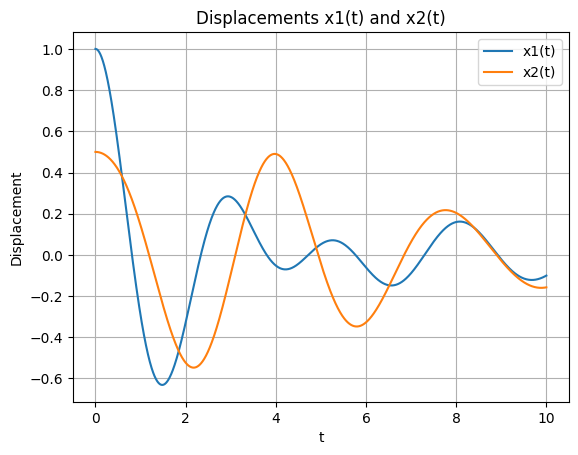

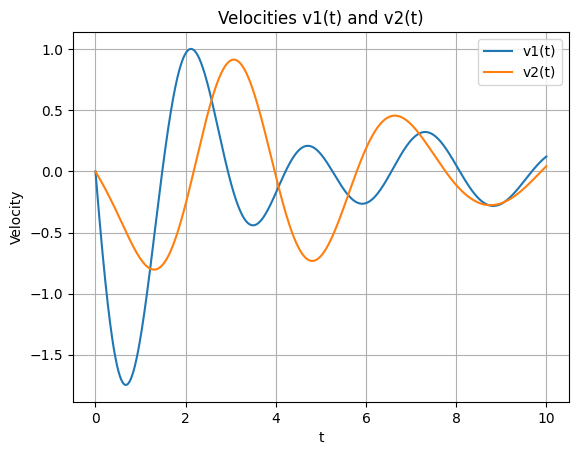

In [4]:
# Solving IVP

def f(t, y):
    """ dy/dt = A·y """
    return A @ y

sol = solve_ivp(f, t_span, y0, t_eval=t_eval, rtol=1e-9, atol=1e-9)

# Graphs
plot_solution(sol)

# Final values
print(f"x1(T) = {sol.y[0,-1]:.6f}, x2(T) = {sol.y[2,-1]:.6f}")    
print(f"v1(T) = {sol.y[1,-1]:.6f}, v2(T) = {sol.y[3,-1]:.6f}")

Next, we attempt the Hamiltonian simulation and try to recover half of the initial condition from it.  

We group the variables as follows:

$$
[x_1, v_1, x_2, v_2] \;\equiv\; [y_1, y_2],
$$

so that each subsystem satisfies

$$
[x_i, v_i] \;\equiv\; [y_i].
$$

The evolution is governed by the unitary operator \(U\):

$$
\begin{bmatrix}
y_1(T) \\[6pt]
y_2(T)
\end{bmatrix}
=
\begin{bmatrix}
U_{00} & U_{01} \\[6pt]
U_{10} & U_{11}
\end{bmatrix}
\begin{bmatrix}
y_1(0) \\[6pt]
y_2(0)
\end{bmatrix}.
$$

Explicitly, this gives

$$
\begin{aligned}
y_1(T) &= U_{00}y_1(0) + U_{01}y_2(0), \\
y_2(T) &= U_{10}y_1(0) + U_{11}y_2(0).
\end{aligned}
$$

---

Now, suppose that the only unknown is $y_2(0)$. From the second equation:

$$
y_1(0) = U_{10}^{-1}\big( y_2(T) - U_{11}y_2(0) \big).
$$

Substituting this into the first equation gives

$$
y_1(T) = U_{00}U_{10}^{-1}\big( y_2(T) - U_{11}y_2(0) \big) + U_{01}y_2(0).
$$



Finally, solving for $y_2(0)$ yields:

$$
y_2(0) = \big(U_{01} - U_{00}U_{10}^{-1}U_{11}\big)^{-1}\big( y_1(T) - U_{00}U_{10}^{-1}y_2(T) \big).
$$


In [5]:
# Funtions

def Four_Partition(C, T):
    """
    C: matrix NxN
    T: Final time
    """
    N = C.shape[0] 
    s = N//2

    Phi_T = expm(C * T)    # e^{C T}= sum_{k=0}^{\infty} (C T)^k / k!
    U00 = Phi_T[:s, :s]    
    U01 = Phi_T[:s, s:]
    U10 = Phi_T[s:, :s]
    U11 = Phi_T[s:, s:]
    return Phi_T, U00, U01, U10, U11


def condition_number(M, name="M", thresh=1e12):
    """ 
    Check if M is invertible by looking at its condition number.
    The condition number is the ratio of the largest to smallest singular value (Singular value: non-negative square root of eigenvalue of M^T M).
    If cond(M) is very large, M is close to singular and numerical errors may be amplified (M can strech or compress space too much in some directions).
    """
    cond = np.linalg.cond(M)
    if cond > thresh:
        print(f"Warning: {name} appears ill-conditioned (cond ≈ {cond:.2e}).")
    return cond

In [6]:
# Exponential matrix and partitions at final time

T = t_span[1]

y10 = y0[:2]          # [x1(0), v1(0)]
y20 = y0[2:]          # [x2(0), v2(0)]     ->   The unknown!
y1T = sol.y[:2, -1]   # [x1(T), v1(T)]
y2T = sol.y[2:, -1]   # [x2(T), v2(T)]

Phi_T, U00, U01, U10, U11 = Four_Partition(A, T)

print("Phi(T):\n", Phi_T)
print("U00:\n", U00)
print("U01:\n", U01)        
print("U10:\n", U10)        
print("U11:\n", U11)



Phi(T):
 [[-0.06748978 -0.02644967 -0.06600164 -0.00573174]
 [ 0.12747188 -0.05474259 -0.00973208 -0.06673602]
 [-0.05503164 -0.00477645 -0.20488721 -0.03563922]
 [-0.00581708 -0.05561335  0.09917127 -0.19348511]]
U00:
 [[-0.06748978 -0.02644967]
 [ 0.12747188 -0.05474259]]
U01:
 [[-0.06600164 -0.00573174]
 [-0.00973208 -0.06673602]]
U10:
 [[-0.05503164 -0.00477645]
 [-0.00581708 -0.05561335]]
U11:
 [[-0.20488721 -0.03563922]
 [ 0.09917127 -0.19348511]]


In [7]:
# Invertibility check of U10 and M

condition_number(U10, "U10")
invU10 = np.linalg.inv(U10)

M = (U01 - U00@invU10@U11)
condition_number(M, "M = U01 - U00 U10^{-1} U11")

y20_recovered = solve(M, y1T -U00@invU10@y2T)


# Consistency check (should be ~0 vector)
print("Recovery error y2(0) - y2(0)_recovered:", y20 - y20_recovered)

Recovery error y2(0) - y2(0)_recovered: [-6.1839337e-09  1.0550948e-08]


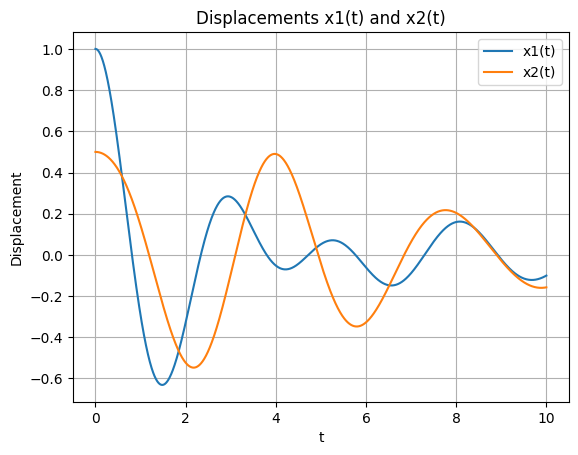

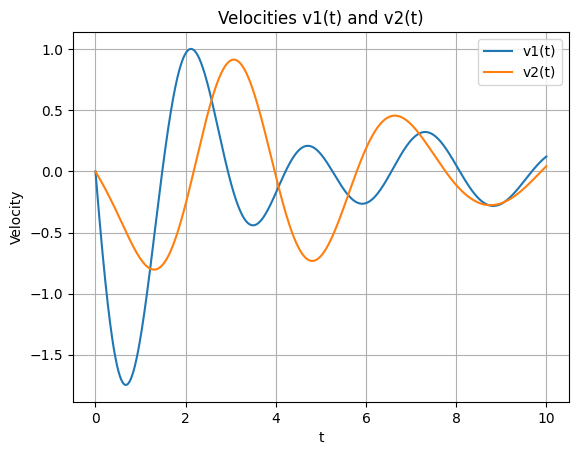

In [8]:
y0_recovered = np.hstack([y10, y20_recovered])
sol_recovered = solve_ivp(f, t_span, y0_recovered, t_eval=t_eval, rtol=1e-9, atol=1e-9)

# Graphs of recovered solution
plot_solution(sol_recovered)

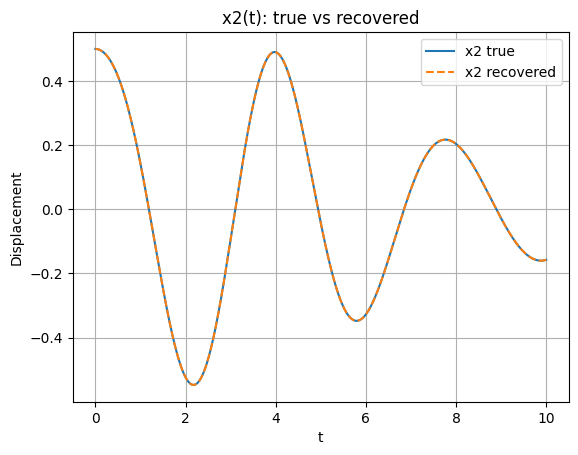

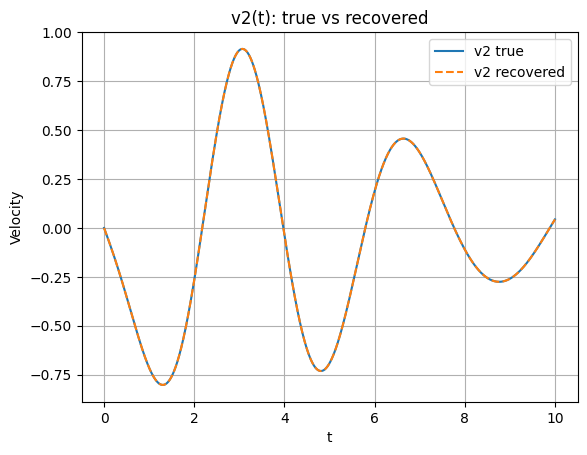

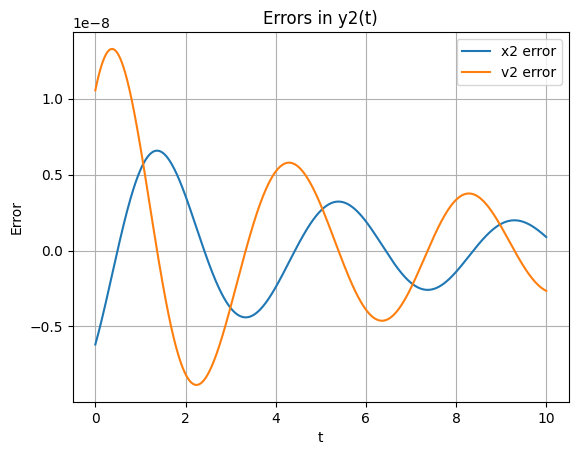

In [9]:
# Comparison:
x2_true, v2_true = sol.y[2],  sol.y[3]
x2_rec,  v2_rec  = sol_recovered.y[2], sol_recovered.y[3]
ex2 = x2_true - x2_rec
ev2 = v2_true - v2_rec

plt.figure()
plt.plot(sol.t, x2_true, label='x2 true')
plt.plot(sol.t, x2_rec,  '--', label='x2 recovered')
plt.xlabel('t'); plt.ylabel('Displacement'); plt.title('x2(t): true vs recovered'); plt.grid(True); plt.legend()

plt.figure()
plt.plot(sol.t, v2_true, label='v2 true')
plt.plot(sol.t, v2_rec,  '--', label='v2 recovered')
plt.xlabel('t'); plt.ylabel('Velocity'); plt.title('v2(t): true vs recovered'); plt.grid(True); plt.legend()

plt.figure()
plt.plot(sol.t, ex2, label='x2 error')
plt.plot(sol.t, ev2, label='v2 error')
plt.xlabel('t'); plt.ylabel('Error'); plt.title('Errors in y2(t)'); plt.grid(True); plt.legend()

plt.show()